### Rheus_macaques_2_Human_Tutorial

This tutorial will illustrate how to perform cell type abundance deconvolution from Rheus_macaques_ifgn dataset to Human_ifgn dataset using GraphDec.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import random
import numpy as np
import scanpy as sc
import pandas as pd

from model import GraphDec
from utils import compute_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Please modify this according to your own situation.

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(42)

Load data. Please make sure you have run `mixup/cross_species.ipynb` in advance.

In [2]:
dataroot = '/public/home/syj/scpDeconv/dataset/mixup_data/' # Please modify this to your address.
dataname = 'Rheus_macaques_2_Human'
data = sc.read_h5ad(dataroot + dataname + '.h5ad')

Data Preprocessing.

In [3]:
if dataname in ['bmmc_15', 'bmmc_50', 'bmmc_200', 'pbmc_data', 'pancreas', 'mouse_brain', 'mouse_PDAC']:
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)

train_data = data[data.obs['batch'] == '0']
test_data = data[data.obs['batch'] != '0']

if train_data.shape[1] > 500:
    sc.pp.highly_variable_genes(train_data, n_top_genes=500)
    test_data = test_data[:, train_data.var_names][:, train_data.var['highly_variable']]
    train_data = train_data[:, train_data.var['highly_variable']]
else:
    test_data = test_data[:, train_data.var_names]

print(train_data)
print(test_data)

View of AnnData object with n_obs × n_vars = 20000 × 39
    obs: 'B', 'CD4 T', 'CD8 T', 'MC', 'NK', 'Neutrophil', 'batch'
    uns: 'cell_types'
View of AnnData object with n_obs × n_vars = 4000 × 39
    obs: 'B', 'CD4 T', 'CD8 T', 'MC', 'NK', 'Neutrophil', 'batch'
    uns: 'cell_types'


Run GraphDec.

In [4]:
model = GraphDec(train_data, test_data)
model.train()
pred = model.prediction(torch.FloatTensor(test_data.X.astype(np.float32)).cuda())

Embedding        : 100%|██████████| 200/200 [00:53<00:00,  3.72it/s]


============= Epoch 100/3000 =============
CCC: 0.53 , RMSE: 0.077 , Pearson: 0.599 , Time: 34.99 s
============= Epoch 200/3000 =============
CCC: 0.809 , RMSE: 0.055 , Pearson: 0.82 , Time: 69.74 s
============= Epoch 300/3000 =============
CCC: 0.936 , RMSE: 0.033 , Pearson: 0.938 , Time: 104.54 s
============= Epoch 400/3000 =============
CCC: 0.946 , RMSE: 0.031 , Pearson: 0.947 , Time: 139.42 s
============= Epoch 500/3000 =============
CCC: 0.948 , RMSE: 0.03 , Pearson: 0.948 , Time: 174.13 s
============= Epoch 600/3000 =============
CCC: 0.947 , RMSE: 0.031 , Pearson: 0.947 , Time: 208.54 s
============= Epoch 700/3000 =============
CCC: 0.952 , RMSE: 0.029 , Pearson: 0.953 , Time: 243.33 s
============= Epoch 800/3000 =============
CCC: 0.949 , RMSE: 0.03 , Pearson: 0.949 , Time: 278.21 s
============= Epoch 900/3000 =============
CCC: 0.957 , RMSE: 0.028 , Pearson: 0.957 , Time: 312.9 s
============= Epoch 1000/3000 =============
CCC: 0.947 , RMSE: 0.031 , Pearson: 0.947 , T

Calculate Quantitative Metrics.

In [5]:
label = np.array([test_data.obs[ctype] for ctype in train_data.uns['cell_types']], dtype=np.float32).T
epoch_ccc, epoch_rmse, epoch_corr = compute_metrics(pred, label)
print('CCC:', round(epoch_ccc, 3), ', RMSE:', round(epoch_rmse, 3), ', Pearson:', round(epoch_corr, 3))

CCC: 0.958 , RMSE: 0.027 , Pearson: 0.958


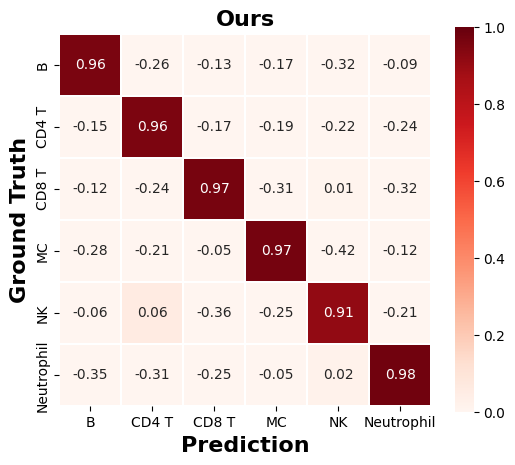

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

def ccc(preds, gt):
    numerator = 2 * np.corrcoef(gt, preds)[0][1] * np.std(gt) * np.std(preds)
    denominator = np.var(gt) + np.var(preds) + (np.mean(gt) - np.mean(preds)) ** 2
    ccc_value = numerator / denominator
    return ccc_value

font = {'weight': 'bold', 'size': 16}

pred = pd.DataFrame(pred, columns=train_data.uns['cell_types'])
label = pd.DataFrame(label, columns=test_data.uns['cell_types'])

df_concatenated = pd.concat([pred, label], axis=1)
res = df_concatenated.corr(method=ccc).iloc[6:, :6]
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.heatmap(res
            , cmap='Reds'
            , linewidths=0.1
            , linecolor='white'
            , square=True
            , robust=True
            , vmax= 1
            , vmin= 0
            , annot=True
            , fmt = '.02f'
           )
 
plt.xlabel('Prediction', color='k', fontdict=font)
plt.ylabel('Ground Truth', color='k', fontdict=font)
plt.title('Ours', fontdict=font)
plt.show()

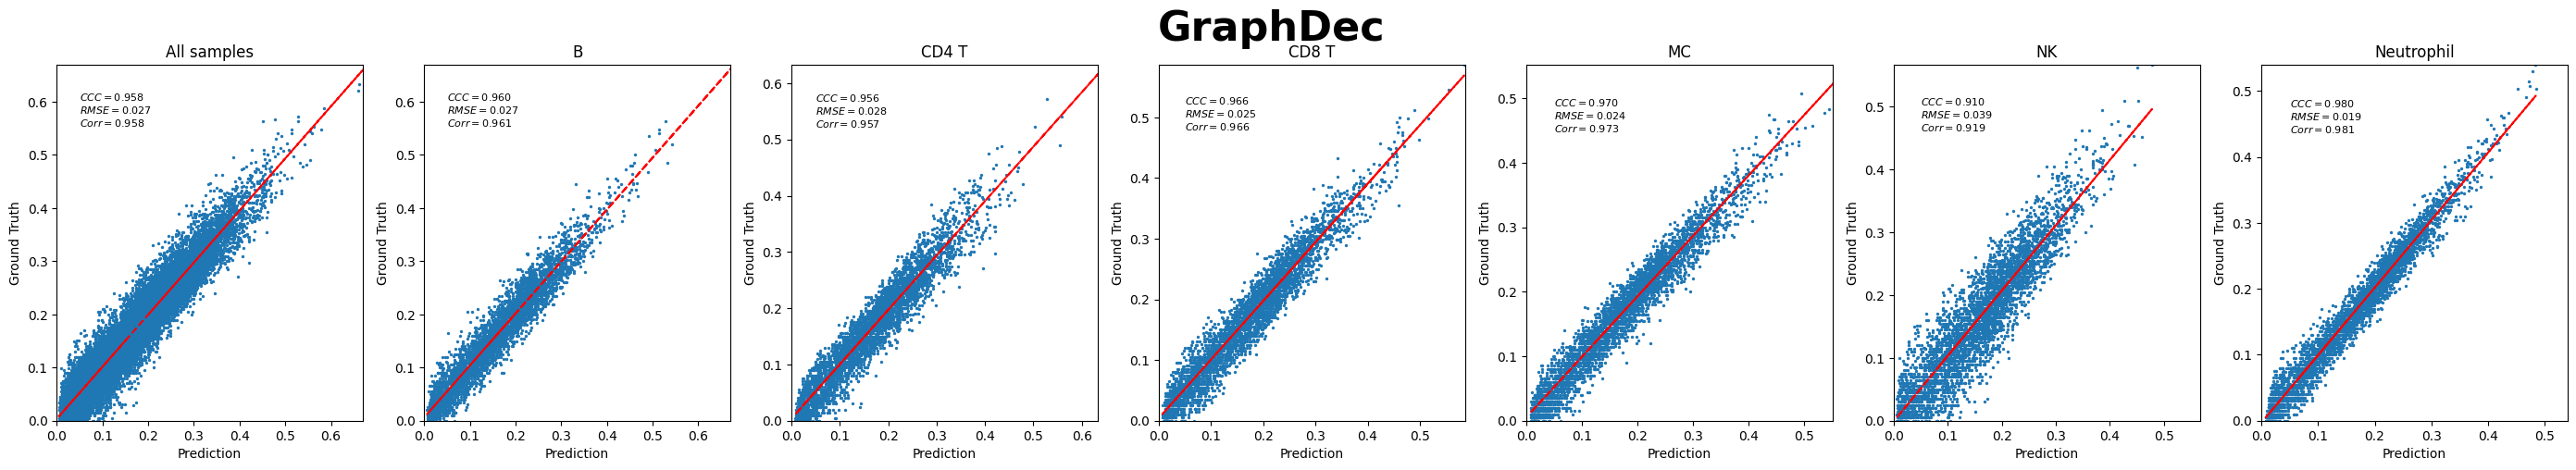

In [7]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt

def SavePredPlot(target_preds, ground_truth):
    target_preds = target_preds[ground_truth.columns]
    celltypes = list(target_preds.columns)
    plt.figure(figsize=(5*(len(celltypes) + 1), 5)) 

    eval_metric = []
    x = target_preds.values.reshape(-1)
    y = ground_truth.values.reshape(-1)
    eval_metric.append(ccc(x, y))
    eval_metric.append(sqrt(mean_squared_error(x, y)))
    eval_metric.append(pearsonr(x, y)[0])
    plt.subplot(1, len(celltypes)+1, 1)
    plt.xlim(0, max(y))
    plt.ylim(0, max(y))
    plt.scatter(x, y, s=2)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    text = f"$CCC = {eval_metric[0]:0.3f}$\n$RMSE = {eval_metric[1]:0.3f}$\n$Corr = {eval_metric[2]:0.3f}$"
    plt.text(0.05, max(y)-0.05, text, fontsize=8, verticalalignment='top')
    plt.title('All samples')
    plt.xlabel('Prediction')
    plt.ylabel('Ground Truth')

    for i in range(len(celltypes)):
        eval_metric = []
        x = target_preds[celltypes[i]]
        y = ground_truth[celltypes[i]]
        eval_metric.append(ccc(x, y))
        eval_metric.append(sqrt(mean_squared_error(x, y)))
        eval_metric.append(pearsonr(x, y)[0])
        plt.subplot(1, len(celltypes)+1, i+2)
        plt.xlim(0, max(y))
        plt.ylim(0, max(y))
        plt.scatter(x, y, s=2)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x,p(x),"r--")
        text = f"$CCC = {eval_metric[0]:0.3f}$\n$RMSE = {eval_metric[1]:0.3f}$\n$Corr = {eval_metric[2]:0.3f}$"
        plt.text(0.05, max(y)-0.05, text, fontsize=8, verticalalignment='top')
        plt.title(celltypes[i])
        plt.xlabel('Prediction')
        plt.ylabel('Ground Truth')
    plt.suptitle('GraphDec', fontsize=32, y=1, fontweight='bold')
    plt.show()
    plt.close()

SavePredPlot(pred, label)